## Attraction sweep and clustering transition

In this notebook, we systematically study how the strength of attraction affects
the emergence of spatial clustering in our simplified universe model.

All parameters except the attraction strength are kept fixed
(noise level, system size, and simulation length).
For each attraction value, multiple simulations with different random seeds
are performed in order to obtain statistically robust results.

In [1]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS

[bootstrap] PROJECT_ROOT = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe
[bootstrap] RESULTS_DIR  = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/results
[bootstrap] FIGURES_DIR  = /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/figures


In [2]:
from src.config import SimConfig, MetricsConfig

We define spatial clusters using a distance-based criterion with threshold ε = 0.06.
This value is chosen to be small compared to the system size, ensuring that clusters correspond to genuinely local density enhancements rather than global connectivity.
All results in this section are obtained with this fixed clustering definition.

In [3]:
SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.10,       
    noise=0.03,            
    interaction_range=0.30, 
)

MET = MetricsConfig(
    eps=0.06,
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from src.experiments import run_sweep, summarize

A_values = np.linspace(0.0, 0.20, 11)
seeds = DEFAULT_SEEDS 

In [5]:
df_raw = run_sweep(
    SIM,
    MET,
    sweep_name="attraction",
    sweep_values=A_values,
    seeds=seeds,
)

df_sum = summarize(df_raw, by="attraction")

raw_path = RESULTS_DIR / "attraction_sweep_raw.csv"
sum_path = RESULTS_DIR / "attraction_sweep_summary.csv"

df_raw.to_csv(raw_path, index=False)
df_sum.to_csv(sum_path, index=False)

print("Saved:", raw_path)
print("Saved:", sum_path)

df_sum.head()

Saved: /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/results/attraction_sweep_raw.csv
Saved: /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe/results/attraction_sweep_summary.csv


,attraction,nn_mean_mean,nn_mean_std,densvar_mean_mean,densvar_mean_std,lcf_mean_mean,lcf_mean_std,nclusters_mean_mean,nclusters_mean_std,lcf_time_std_mean,lcf_time_std_std,runtime_sec_mean,runtime_sec_std
0,0.00,0.028944,0.000207,1.322356,0.024714,0.314100,0.023916,31.01,1.072070,0.124002,0.022725,4.751112,0.071162
1,0.02,0.028756,0.000176,1.362222,0.033462,0.389833,0.034212,31.75,0.889444,0.135294,0.014838,4.769555,0.128853
2,0.04,0.019206,0.000456,4.534933,0.183879,0.925333,0.006364,16.37,1.148719,0.019744,0.003690,4.751280,0.022460
3,0.06,0.013721,0.000159,8.216533,0.125589,0.974383,0.002773,6.92,0.600555,0.009677,0.001704,4.849630,0.075786
4,0.08,0.011341,0.000117,11.229422,0.207262,0.987567,0.001637,4.18,0.378006,0.006260,0.001281,4.909562,0.063619


In [6]:
import numpy as np
A_values = np.linspace(0.0, 0.20, 11)

In [7]:

from dataclasses import asdict

A = A_values[0]  
sim = SimConfig(**{**asdict(SIM), "attraction": float(A)})
sim

SimConfig(N=300, steps=1500, dt=1.0, box_size=1.0, save_every=30, attraction=0.0, interaction_range=0.3, noise=0.03, repulsion=0.02, repulsion_radius=0.05)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src.universe_sim import run_simulation
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

We keep the following parameters fixed throughout the experiment:

- Number of particles: N = 300  
- Number of time steps: 400  
- Box size: 1.0  
- Noise strength: 0.03  

Only the attraction strength will be varied.

In [9]:
# Fixed simulation settings
N = 300
steps = 400
box_size = 1.0
noise = 0.03

# Parameters for clustering metric
eps = 0.05   # distance threshold for largest cluster fraction

# Attraction values to scan
A_values = np.linspace(0.0, 0.20, 11)

# Random seeds for repeated runs
seeds = [0, 1, 2, 3, 4]

To avoid code duplication, we define a small helper function that runs one
simulation for a given attraction strength and random seed, and returns the
clustering observables measured at the final time step.

In [10]:
def run_single_simulation(A, seed):
    np.random.seed(seed)

    history = run_simulation(
        N=N,
        steps=steps,
        box_size=box_size,
        attraction=A,
        noise=noise
    )

    final_positions = history[-1]

    nn_distance = nearest_neighbor_distance(
        final_positions, box_size=box_size
    )
    largest_cluster = largest_cluster_fraction(
        final_positions, eps=eps, box_size=box_size
    )

    return nn_distance, largest_cluster

For each attraction value, we run the simulation five times with different
random seeds.  
We then compute the mean and standard deviation of the observables.

In [11]:
nn_mean, nn_std = [], []
lc_mean, lc_std = [], []

for A in A_values:
    nn_values = []
    lc_values = []

    for seed in seeds:
        nn, lc = run_single_simulation(A, seed)
        nn_values.append(nn)
        lc_values.append(lc)

    nn_mean.append(np.mean(nn_values))
    nn_std.append(np.std(nn_values))

    lc_mean.append(np.mean(lc_values))
    lc_std.append(np.std(lc_values))

nn_mean = np.array(nn_mean)
nn_std = np.array(nn_std)
lc_mean = np.array(lc_mean)
lc_std = np.array(lc_std)

The largest cluster fraction can be interpreted as an order-parameter–like
quantity:  

- Values close to zero indicate a nearly uniform configuration  
- Large values indicate the presence of a dominant cluster  

We therefore plot this quantity as a function of attraction strength.

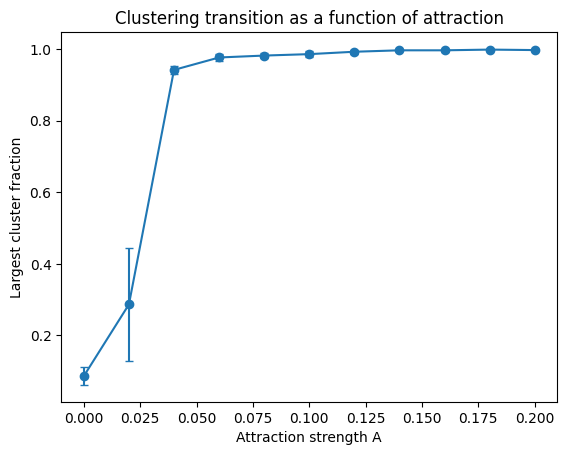

In [12]:
plt.figure()
plt.errorbar(A_values, lc_mean, yerr=lc_std, fmt="o-", capsize=3)
plt.xlabel("Attraction strength A")
plt.ylabel("Largest cluster fraction")
plt.title("Clustering transition as a function of attraction")
plt.show()

As a complementary observable, we also examine the average nearest-neighbour
distance.  
A decreasing distance typically corresponds to stronger clustering.

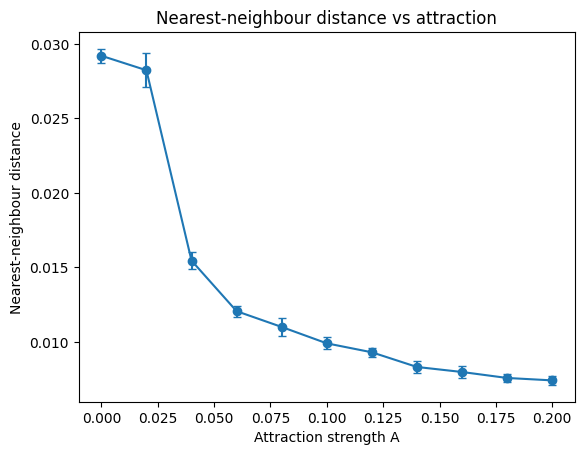

In [13]:
plt.figure()
plt.errorbar(A_values, nn_mean, yerr=nn_std, fmt="o-", capsize=3)
plt.xlabel("Attraction strength A")
plt.ylabel("Nearest-neighbour distance")
plt.title("Nearest-neighbour distance vs attraction")
plt.show()

In addition to the order parameter, we examine the temporal fluctuations of the largest cluster fraction.
We observe a pronounced peak in the fluctuations near the transition point, consistent with critical behaviour.

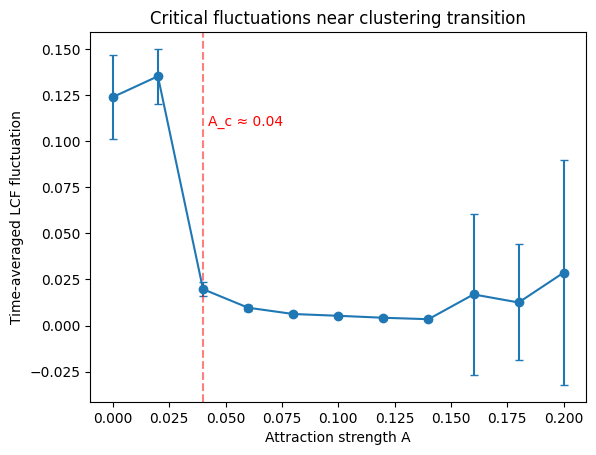

In [ ]:
import matplotlib.pyplot as plt

A = df_sum["attraction"]
y = df_sum["lcf_time_std_mean"]
yerr = df_sum["lcf_time_std_std"]

plt.figure()
plt.errorbar(A, y, yerr=yerr, fmt="o-", capsize=3)
plt.xlabel("Attraction strength A")
plt.ylabel("Time-averaged LCF fluctuation")
plt.title("Critical fluctuations near clustering transition")


plt.axvline(0.04, color="red", linestyle="--", alpha=0.5)
plt.text(0.042, max(y)*0.8, "A_c ≈ 0.04", color="red")

plt.show()

Finally, we directly visualize particle positions at the final time step for
two representative cases:  

- No attraction (A = 0)  
- Strong attraction (largest A in the sweep)  

This provides a qualitative sanity check of the clustering behaviour.

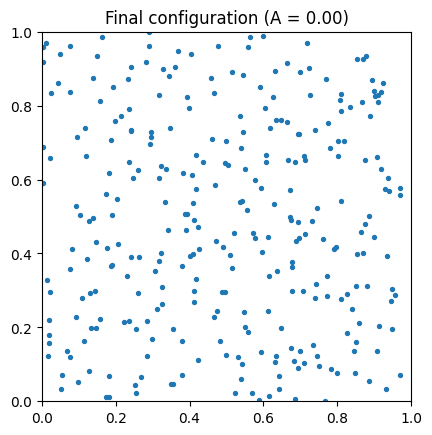

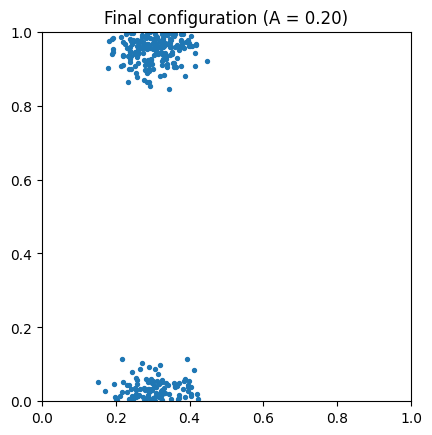

In [16]:
def plot_final_configuration(A, seed=0):
    np.random.seed(seed)
    history = run_simulation(
        N=N,
        steps=steps,
        box_size=box_size,
        attraction=A,
        noise=noise
    )
    positions = history[-1]

    plt.figure()
    plt.scatter(positions[:, 0], positions[:, 1], s=8)
    plt.xlim(0, box_size)
    plt.ylim(0, box_size)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Final configuration (A = {A:.2f})")
    plt.show()


plot_final_configuration(A=0.0)
plot_final_configuration(A=A_values[-1])

## Interpretation of the attraction sweep

For very small attraction strengths, particles remain approximately uniformly
distributed, as indicated by a small largest cluster fraction and a relatively
large nearest-neighbour distance.

As the attraction strength increases beyond a critical value, we observe a
sharp increase in the size of the largest cluster, accompanied by a rapid
decrease in the nearest-neighbour distance. This suggests the emergence of a
giant cluster and a phase-transition-like behaviour in the system.

For larger attraction strengths, the system saturates into a single dominant
cluster, and both observables become relatively insensitive to further increases
in attraction.
